# TAREA # 2 ESTADISTICA 3 ALEJANDRO ARBELÁEZ HOYOS

In [ ]:
import csv
import math
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score, precision_score



## Regresión

### 1. Realizar la exploración de los datos correlación, scatter plots, boxplots e histogramas

#### 1.1 ¿Qué variables son importantes para predecir el valor?


In [ ]:
est_train_raw = pd.read_csv("./Insumos/training_pruebas.csv", low_memory=False) ##

In [8]:
irrelevant_cols = [
    "ESTU_TIPODOCUMENTO", "ESTU_NACIONALIDAD","PERIODO","ESTU_CONSECUTIVO","ESTU_ESTUDIANTE","ESTU_PAIS_RESIDE",
    "ESTU_DEPTO_RESIDE","ESTU_MCPIO_RESIDE","ESTU_ESTADOCIVIL","ESTU_TIPODOCUMENTOSB11","FAMI_EDUCACIONPADRE","FAMI_EDUCACIONMADRE",
    "FAMI_TRABAJOLABORPADRE","FAMI_TRABAJOLABORMADRE","FAMI_CUANTOSCOMPARTEBAÑO",
    "ESTU_PRESENTACIONCASA","ESTU_PRESENTACIONSABADO","INST_NOMBRE_INSTITUCION","ESTU_PRGM_ACADEMICO","GRUPOREFERENCIA",
    "ESTU_PRGM_MUNICIPIO","ESTU_PRGM_DEPARTAMENTO","ESTU_NUCLEO_PREGRADO","ESTU_NUCLEO_PREGRADO_1",
    "ESTU_INST_MUNICIPIO","ESTU_INST_DEPARTAMENTO","INST_CARACTER_ACADEMICO","INST_ORIGEN","ESTU_MCPIO_PRESENTACION",
    "ESTU_DEPTO_PRESENTACION","ESTU_ESTADOINVESTIGACION", "ESTU_COD_RESIDE_DEPTO", "ESTU_COD_RESIDE_MCPIO",
    "ESTU_SNIES_PRGMACADEMICO","ESTU_PRGM_CODMUNICIPIO","ESTU_INST_CODMUNICIPIO","ESTU_COD_MCPIO_PRESENTACION","ESTU_COD_DEPTO_PRESENTACION"
]

est_train = est_train_raw.drop(columns = irrelevant_cols)

#### 1.2 Existen nulos?, ¿cómo se deben imputar?

In [22]:
continuous_cols = ["ESTU_INSE_INDIVIDUAL", "ESTU_NSE_INDIVIDUAL", "ESTU_NSE_IES"]
categorical_cols = [col for col in est_train.columns if col not in continuous_cols and col != "PUNT_GLOBAL"]

def fix_nulls(data):
    new_data = data.copy()

    # Llenar nulos con la media para variables numéricas
    new_data[continuous_cols] = new_data[continuous_cols].apply(lambda col: col.fillna(col.mean()), axis=0)

    # Llenar nulos con la moda para variables categóricas
    new_data[categorical_cols] = new_data[categorical_cols].apply(lambda col: col.fillna(col.mode()[0]), axis=0)

    return new_data

# Aplicar la función para imputar valores nulos
est_train = fix_nulls(est_train)

# Llenar nulos en la columna "PUNT_GLOBAL" con su media
est_train["PUNT_GLOBAL"].fillna(est_train["PUNT_GLOBAL"].mean(), inplace=True)

C:\Users\MrDroky\AppData\Local\Temp\ipykernel_18204\3363735324.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  est_train["PUNT_GLOBAL"].fillna(est_train["PUNT_GLOBAL"].mean(), inplace=True)


#### 1.3 Crear dummy variables para incluirlas en la correlación

Primero voy a sanitizar algunas variables catégoricas, para no crear demasiados dummies

In [23]:
def transform_data(data):

    # Obtener edad actual de cada persona
    data["ESTU_FECHANACIMIENTO"] = pd.to_datetime(data["ESTU_FECHANACIMIENTO"], format="mixed", dayfirst=True, errors='coerce')
    today = pd.to_datetime('today', format="%d/%m/%Y")
    data["ESTU_FECHANACIMIENTO"] = data["ESTU_FECHANACIMIENTO"].apply(lambda x: today.year - x.year - ((today.month, today.day) < (x.month, x.day)))
    age_mean = data["ESTU_FECHANACIMIENTO"].mean()

    for i, val in enumerate(data["ESTU_FECHANACIMIENTO"]):
        if str(val) == 'nan':
            data.loc[i, "ESTU_FECHANACIMIENTO"] = age_mean

    # Trasnformar valores binomiales

    # Genero (M: 0, F: 1)
    data["ESTU_GENERO"] = data["ESTU_GENERO"].apply(lambda x: 1 if x == 'F' else 0)

    # Estudia en el exterior (NO: 0, SI: 1)
    data["ESTU_EXTERIOR"] = data["ESTU_EXTERIOR"].apply(lambda x: 1 if x == 'SI' else 0)

    # Área de residencia (Area Rural: 0, Cabecera Municipal: 1)
    data["ESTU_AREARESIDE"] = data["ESTU_AREARESIDE"].apply(lambda x: 1 if x == 'Cabecera Municipal' else 0)

    # Pago con beca
    data["ESTU_PAGOMATRICULABECA"] = data["ESTU_PAGOMATRICULABECA"].apply(lambda x: 1 if x == 'Si' else 0)
    # Pago con crédito
    data["ESTU_PAGOMATRICULACREDITO"] = data["ESTU_PAGOMATRICULACREDITO"].apply(lambda x: 1 if x == 'Si' else 0)
    # Pago con padres
    data["ESTU_PAGOMATRICULAPADRES"] = data["ESTU_PAGOMATRICULAPADRES"].apply(lambda x: 1 if x == 'Si' else 0)
    # Pago propio
    data["ESTU_PAGOMATRICULAPROPIO"] = data["ESTU_PAGOMATRICULAPROPIO"].apply(lambda x: 1 if x == 'Si' else 0)

    # Hizo simulacro
    data["ESTU_SIMULACROTIPOICFES"] = data["ESTU_SIMULACROTIPOICFES"].apply(lambda x: 1 if x == 'Si' else 0)
    # Hizo actividades de refuerzo en áreas
    data["ESTU_ACTIVIDADREFUERZOAREAS"] = data["ESTU_ACTIVIDADREFUERZOAREAS"].apply(lambda x: 1 if x == 'Si' else 0)
    # Hizo actividades de refuerzo genéricas
    data["ESTU_ACTIVIDADREFUERZOGENERIC"] = data["ESTU_ACTIVIDADREFUERZOGENERIC"].apply(lambda x: 1 if x == 'Si' else 0)

    # Tiene internet
    data["FAMI_TIENEINTERNET"] = data["FAMI_TIENEINTERNET"].apply(lambda x: 1 if x == 'Si' else 0)
    # Tiene computador
    data["FAMI_TIENECOMPUTADOR"] = data["FAMI_TIENECOMPUTADOR"].apply(lambda x: 1 if x == 'Si' else 0)
    # Tiene lavadora
    data["FAMI_TIENELAVADORA"] = data["FAMI_TIENELAVADORA"].apply(lambda x: 1 if x == 'Si' else 0)
    # Tiene microondas
    data["FAMI_TIENEHORNOMICROOGAS"] = data["FAMI_TIENEHORNOMICROOGAS"].apply(lambda x: 1 if x == 'Si' else 0)
    # Tiene TV
    data["FAMI_TIENESERVICIOTV"] = data["FAMI_TIENESERVICIOTV"].apply(lambda x: 1 if x == 'Si' else 0)
    # Tiene automovil
    data["FAMI_TIENEAUTOMOVIL"] = data["FAMI_TIENEAUTOMOVIL"].apply(lambda x: 1 if x == 'Si' else 0)
    # Tiene motocicleta
    data["FAMI_TIENEMOTOCICLETA"] = data["FAMI_TIENEMOTOCICLETA"].apply(lambda x: 1 if x == 'Si' else 0)
    # Tiene consola de videojuegos
    data["FAMI_TIENECONSOLAVIDEOJUEGOS"] = data["FAMI_TIENECONSOLAVIDEOJUEGOS"].apply(lambda x: 1 if x == 'Si' else 0)

    # Método del programa (PRESENCIAL: 0 DISTANCIA VITUAL: 1)
    data["ESTU_METODO_PRGM"] = data["ESTU_METODO_PRGM"].apply(lambda x: 1 if x == 'DISTANCIA VITUAL' else 0)

    # Privado de libertad
    data["ESTU_PRIVADO_LIBERTAD"] = data["ESTU_PRIVADO_LIBERTAD"].apply(lambda x: 1 if x == 'S' else 0)

transform_data(est_train)
print("Nulos: ", np.nonzero(pd.isnull(est_train)))
est_train

Nulos:  (array([], dtype=int64), array([], dtype=int64))


,ESTU_GENERO,ESTU_FECHANACIMIENTO,ESTU_EXTERIOR,ESTU_AREARESIDE,ESTU_TITULOOBTENIDOBACHILLER,ESTU_VALORMATRICULAUNIVERSIDAD,ESTU_PAGOMATRICULABECA,ESTU_PAGOMATRICULACREDITO,ESTU_PAGOMATRICULAPADRES,ESTU_PAGOMATRICULAPROPIO,...,ESTU_PAGOMATRICULA,ESTU_VLRULTIMOSEMESCURSADO,INST_COD_INSTITUCION,ESTU_NIVEL_PRGM_ACADEMICO,ESTU_METODO_PRGM,ESTU_PRIVADO_LIBERTAD,PUNT_GLOBAL,ESTU_INSE_INDIVIDUAL,ESTU_NSE_INDIVIDUAL,ESTU_NSE_IES
0,0,55,0,0,Bachiller académico,Entre 500 mil y menos de 1 millón,0,0,0,0,...,Familiares,Menos de 500 mil pesos,1202,UNIVERSITARIO,0,0,188,55.570156,3.000000,2
1,0,55,0,0,Bachiller académico,Entre 1 millón y menos de 2.5 millones,0,0,0,0,...,Becas o Subsidios,Menos de 500 mil pesos,2102,UNIVERSITARIO,0,0,140,38.105883,1.000000,2
2,0,55,0,0,Bachiller académico,Entre 1 millón y menos de 2.5 millones,0,0,0,0,...,Becas o Subsidios,Menos de 500 mil pesos,2102,UNIVERSITARIO,0,0,140,65.658631,4.000000,2
3,0,55,0,0,Bachiller académico,No pagó matrícula,0,0,0,0,...,Becas o Subsidios,No pago semestre,1218,UNIVERSITARIO,0,0,111,49.260729,2.000000,2
4,0,55,0,0,Bachiller académico,Entre 2.5 millones y menos de 4 millones,0,0,0,0,...,Propios,Entre 3 y 5 millones,2812,UNIVERSITARIO,0,0,135,55.138843,2.000000,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111425,0,55,0,0,Bachiller técnico,No pagó matrícula,0,0,0,0,...,Familiares,Entre un millon y 3 millones de pesose,1107,UNIVERSITARIO,0,0,137,55.028124,2.678834,2
111426,0,55,0,0,Bachiller académico,Entre 4 millones y menos de 5.5 millones,0,0,0,0,...,Familiares,Entre 3 y 5 millones,1805,UNIVERSITARIO,0,0,161,63.619372,4.000000,3
111427,0,55,0,0,Bachiller académico,Entre 2.5 millones y menos de 4 millones,0,0,0,0,...,Creditos,Entre un millon y 3 millones de pesose,4702,UNIVERSITARIO,0,0,124,48.648902,2.000000,2
111428,0,55,0,0,Bachiller académico,Entre 4 millones y menos de 5.5 millones,0,0,0,0,...,Creditos,Entre 3 y 5 millones,1824,UNIVERSITARIO,0,0,142,52.877602,2.000000,4


In [24]:
def normalize(data):
    for i, col in enumerate(data.columns):
        data[col] = 0 if data[col].std() == 0 else (data[col] - data[col].mean()) / data[col].std()

# Crear dummies
est_train_dumm = pd.get_dummies(est_train)
normalize(est_train_dumm)
est_train_dumm

,ESTU_GENERO,ESTU_FECHANACIMIENTO,ESTU_EXTERIOR,ESTU_AREARESIDE,ESTU_PAGOMATRICULABECA,ESTU_PAGOMATRICULACREDITO,ESTU_PAGOMATRICULAPADRES,ESTU_PAGOMATRICULAPROPIO,ESTU_SIMULACROTIPOICFES,ESTU_ACTIVIDADREFUERZOAREAS,...,ESTU_PAGOMATRICULA_Creditos,ESTU_PAGOMATRICULA_Familiares,ESTU_VLRULTIMOSEMESCURSADO_Entre 3 y 5 millones,ESTU_VLRULTIMOSEMESCURSADO_Entre 5 y 7 millones,ESTU_VLRULTIMOSEMESCURSADO_Entre 500 mil y un millon de pesos,ESTU_VLRULTIMOSEMESCURSADO_Entre un millon y 3 millones de pesose,ESTU_VLRULTIMOSEMESCURSADO_Mas de 7 millones,ESTU_VLRULTIMOSEMESCURSADO_Menos de 500 mil pesos,ESTU_VLRULTIMOSEMESCURSADO_No pago semestre,ESTU_NIVEL_PRGM_ACADEMICO_UNIVERSITARIO
0,0,0,0,0,0,0,0,0,0,0,...,-0.547684,1.485369,-0.456533,-0.273497,-0.239647,-0.704445,-0.276743,2.582217,-0.453214,0
1,0,0,0,0,0,0,0,0,0,0,...,-0.547684,-0.673227,-0.456533,-0.273497,-0.239647,-0.704445,-0.276743,2.582217,-0.453214,0
2,0,0,0,0,0,0,0,0,0,0,...,-0.547684,-0.673227,-0.456533,-0.273497,-0.239647,-0.704445,-0.276743,2.582217,-0.453214,0
3,0,0,0,0,0,0,0,0,0,0,...,-0.547684,-0.673227,-0.456533,-0.273497,-0.239647,-0.704445,-0.276743,-0.387261,2.206445,0
4,0,0,0,0,0,0,0,0,0,0,...,-0.547684,-0.673227,2.190403,-0.273497,-0.239647,-0.704445,-0.276743,-0.387261,-0.453214,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111425,0,0,0,0,0,0,0,0,0,0,...,-0.547684,1.485369,-0.456533,-0.273497,-0.239647,1.419545,-0.276743,-0.387261,-0.453214,0
111426,0,0,0,0,0,0,0,0,0,0,...,-0.547684,1.485369,2.190403,-0.273497,-0.239647,-0.704445,-0.276743,-0.387261,-0.453214,0
111427,0,0,0,0,0,0,0,0,0,0,...,1.825854,-0.673227,-0.456533,-0.273497,-0.239647,1.419545,-0.276743,-0.387261,-0.453214,0
111428,0,0,0,0,0,0,0,0,0,0,...,1.825854,-0.673227,2.190403,-0.273497,-0.239647,-0.704445,-0.276743,-0.387261,-0.453214,0


#### 1.4 Crear una correlación, que variables tienen un efecto positivo en el puntaje y cuales un efecto negativo.

In [ ]:
est_train_dumm.corrwith(est_train_dumm["PUNT_GLOBAL"]).sort_values(ascending=False).iloc[1:]


c:\Users\MrDroky\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\MrDroky\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


ESTU_NSE_IES                                        0.262818
ESTU_VALORMATRICULAUNIVERSIDAD_Más de 7 millones    0.244534
ESTU_INSE_INDIVIDUAL                                0.238292
ESTU_NSE_INDIVIDUAL                                 0.215721
ESTU_VLRULTIMOSEMESCURSADO_Mas de 7 millones        0.213380
                                                      ...   
FAMI_TIENEMOTOCICLETA                                    NaN
FAMI_TIENECONSOLAVIDEOJUEGOS                             NaN
ESTU_METODO_PRGM                                         NaN
ESTU_PRIVADO_LIBERTAD                                    NaN
ESTU_NIVEL_PRGM_ACADEMICO_UNIVERSITARIO                  NaN
Length: 108, dtype: float64

Al realizar la correlación de cada variable contra PUNT_GLOBAL, se pueden observar las variables que tienen un efecto positivo en la parte superior; y las que tienen un efecto negativo en la parte inferior. El nivel socioeconómico es la variable que más influencia en el puntaje global.

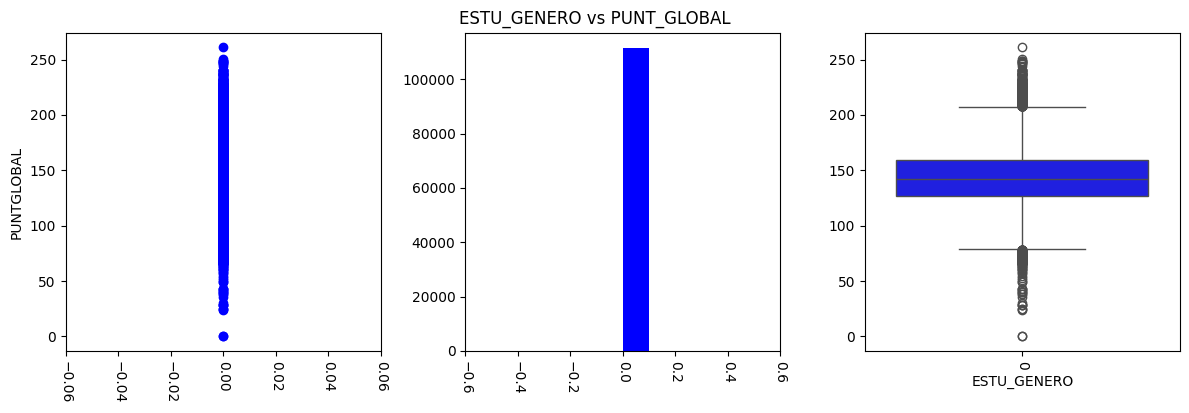

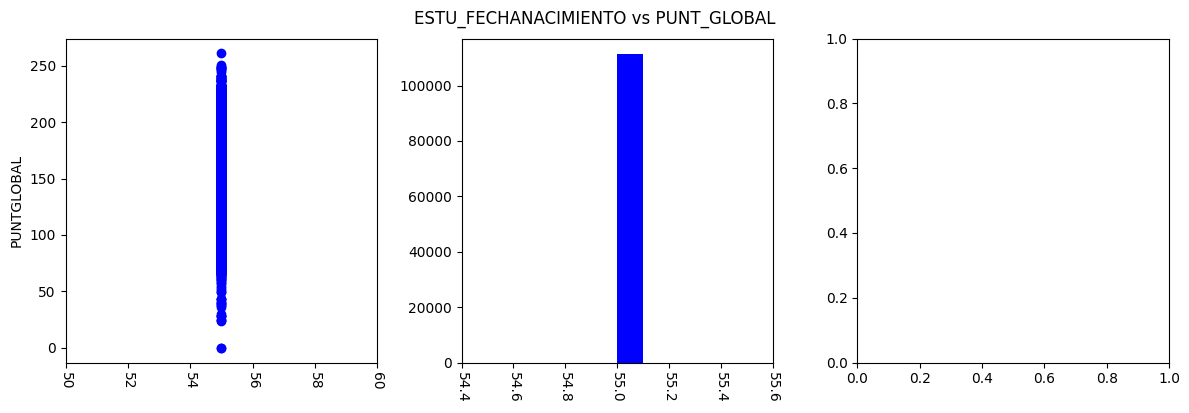

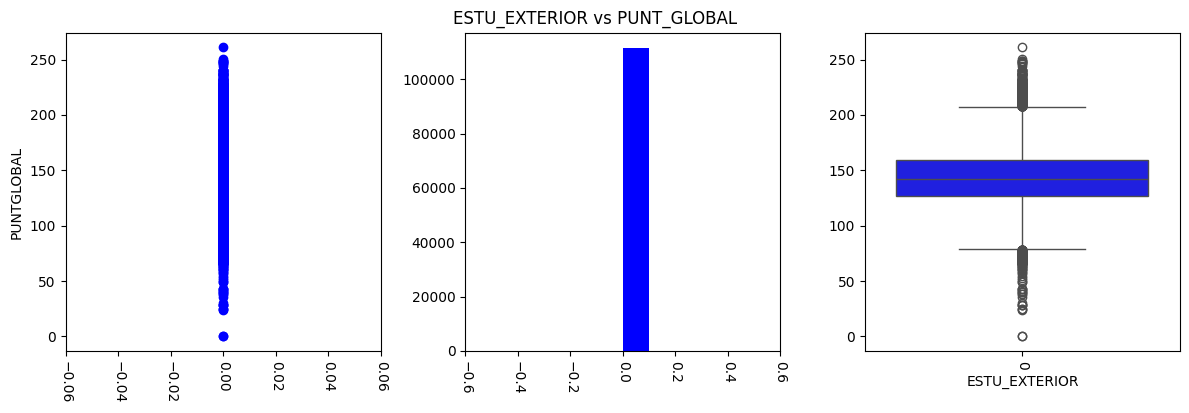

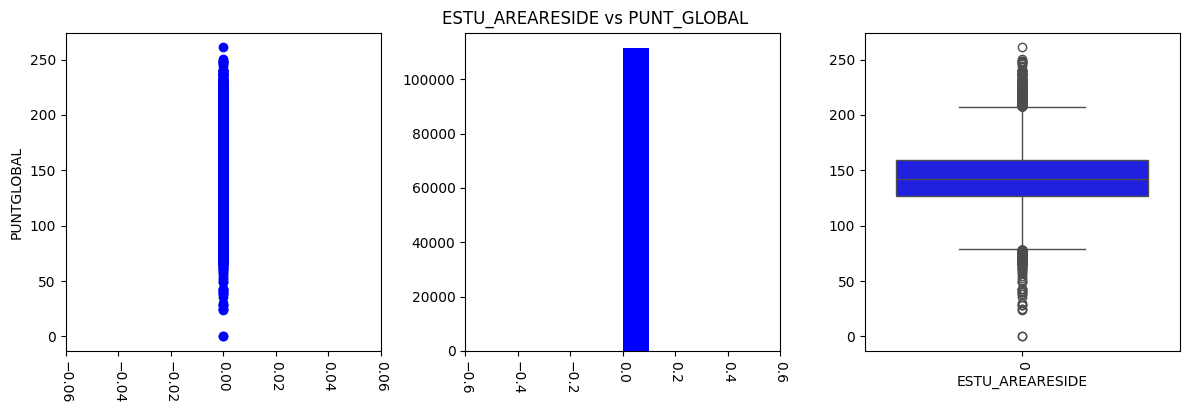

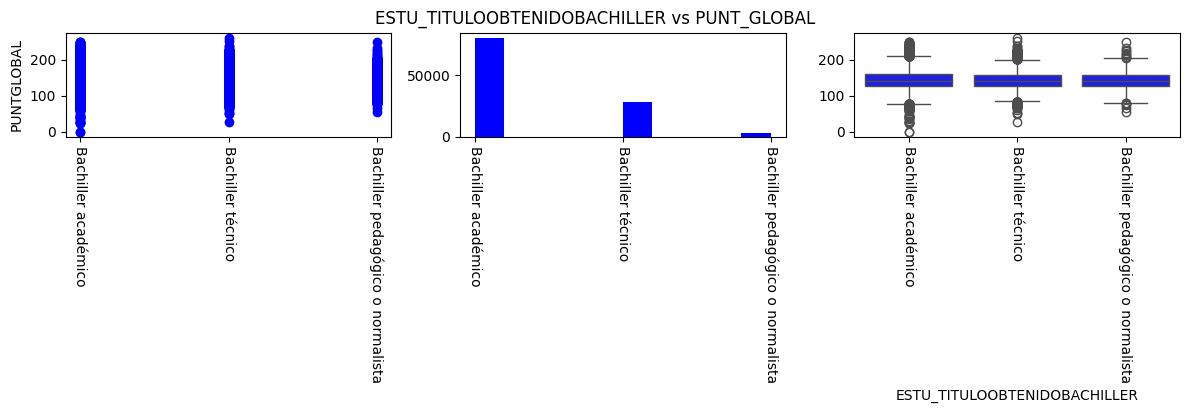

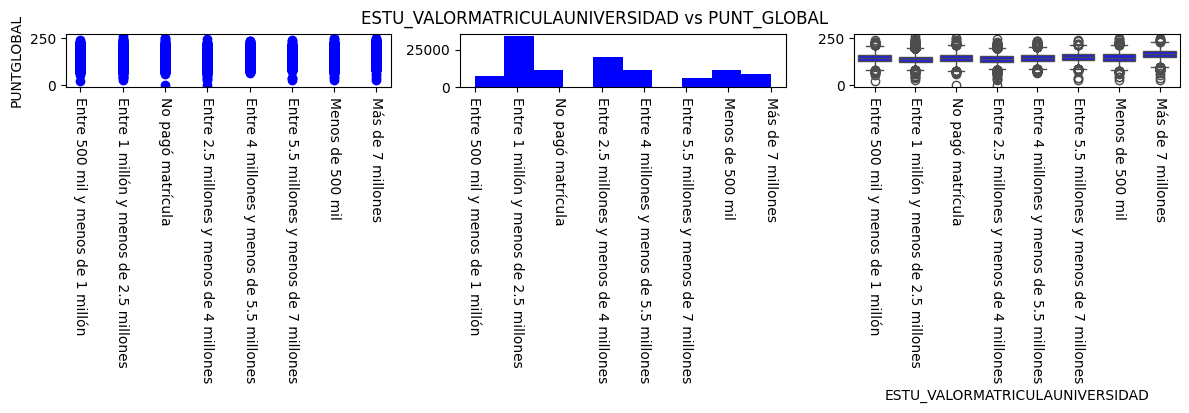

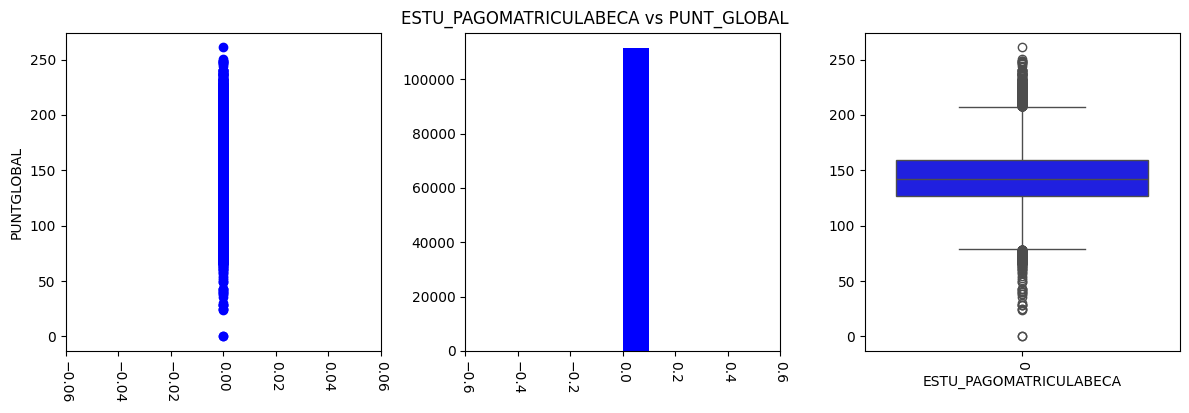

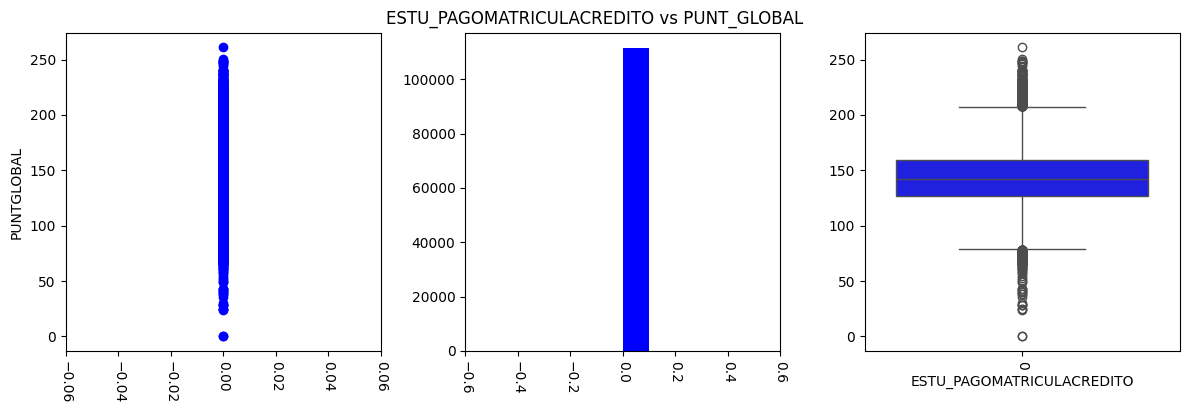

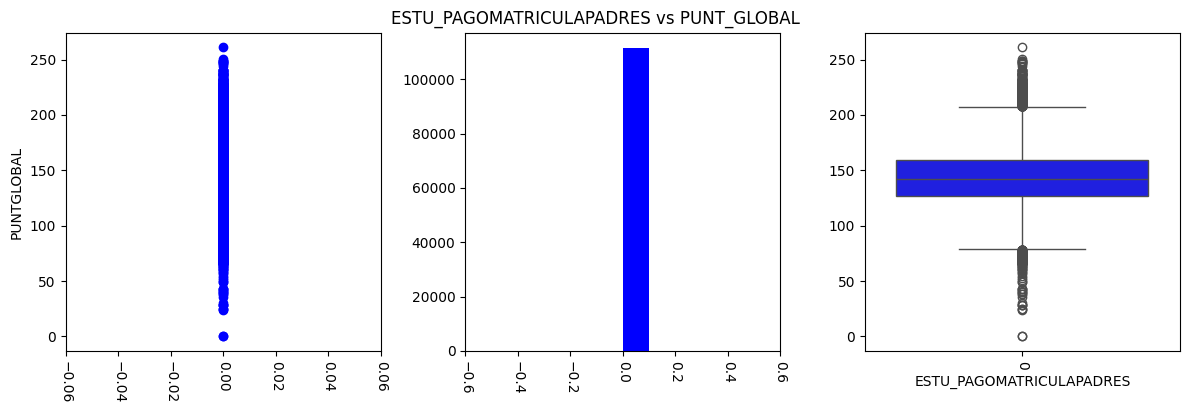

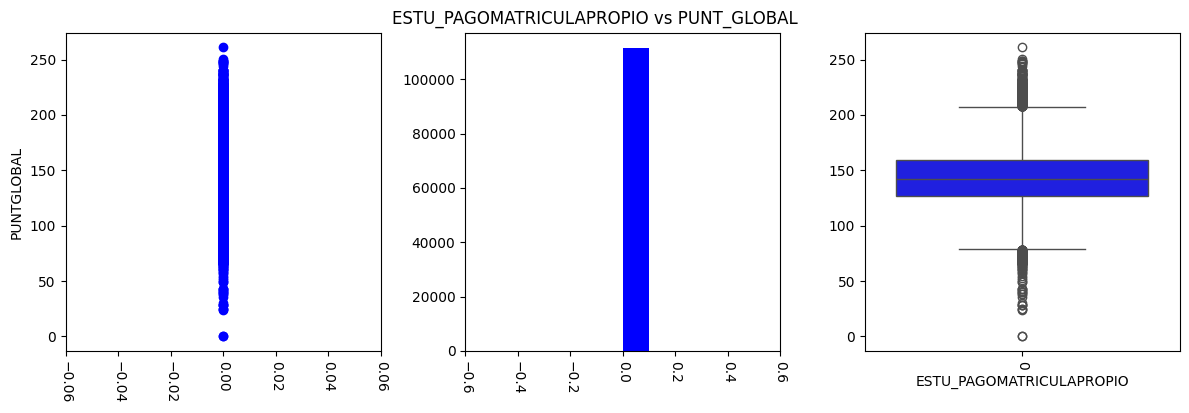

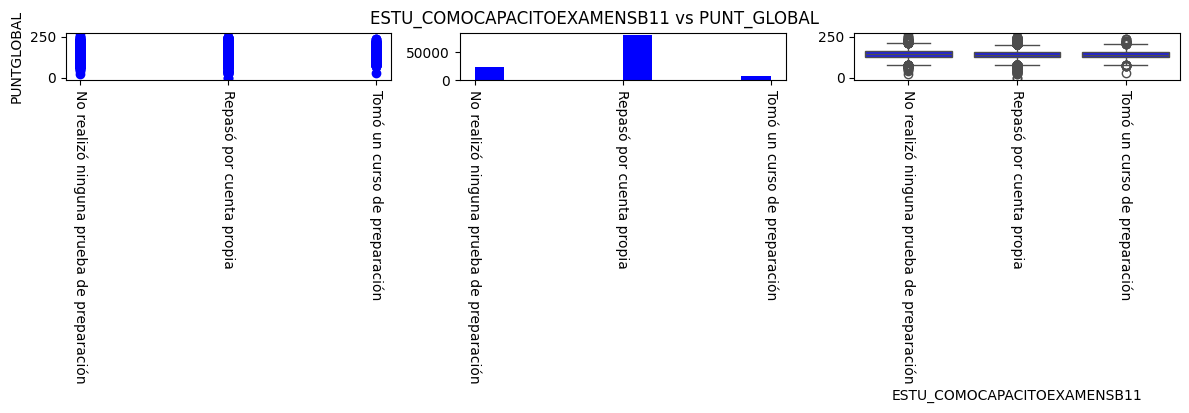

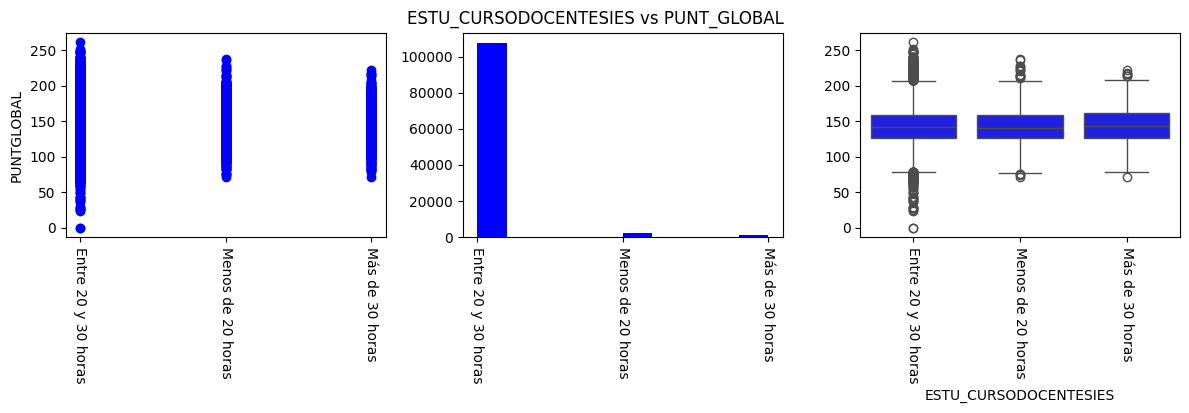

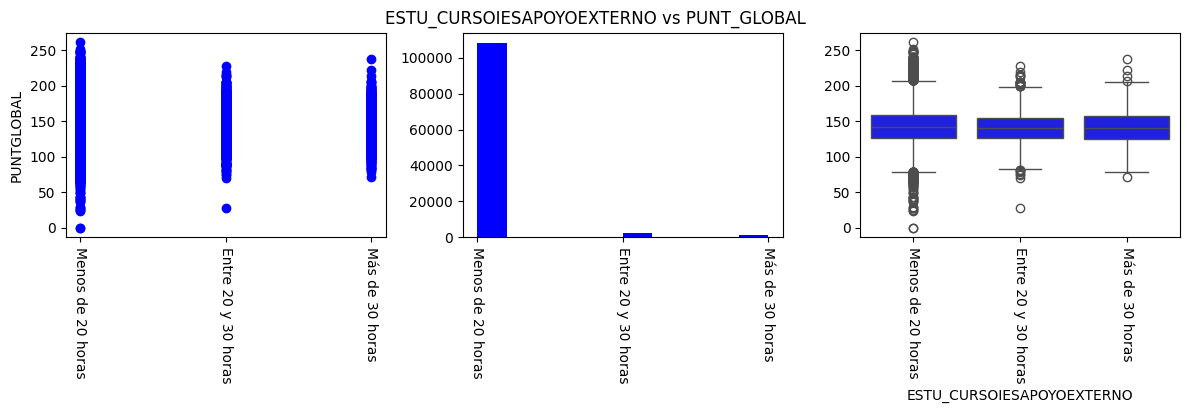

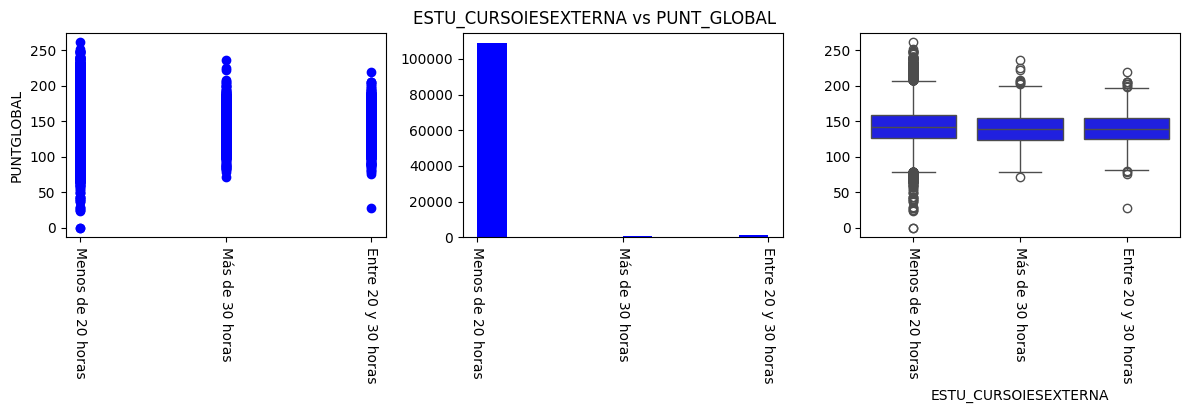

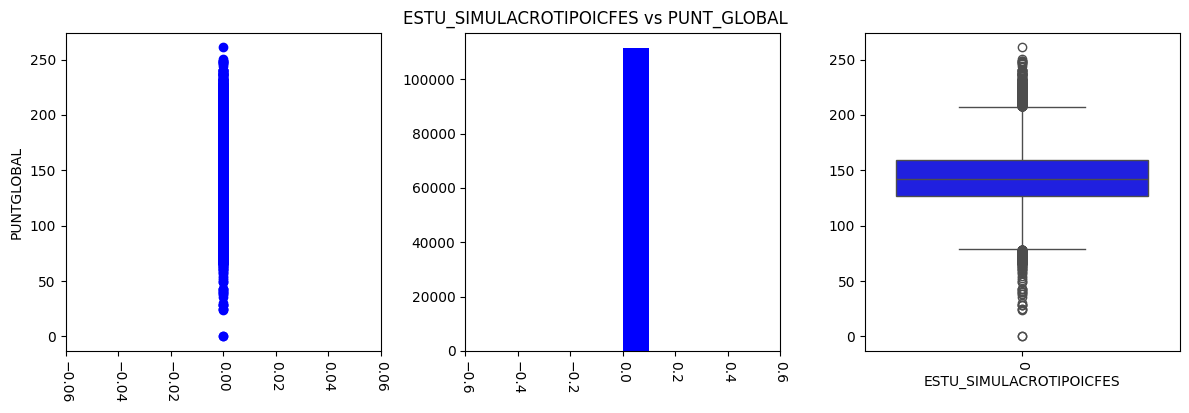

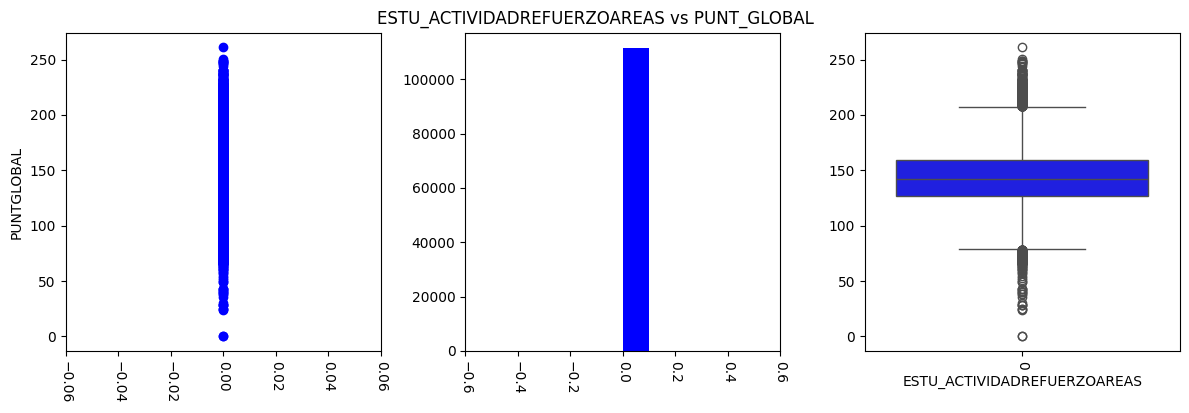

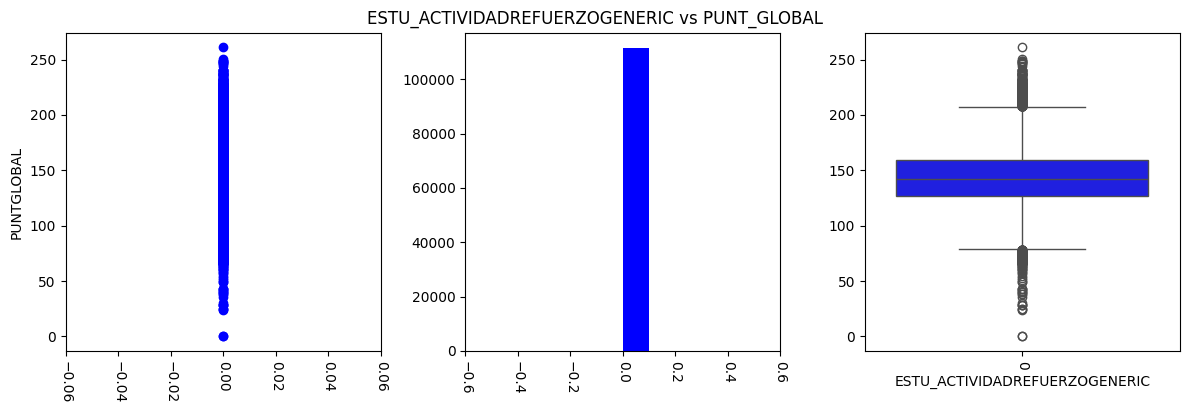

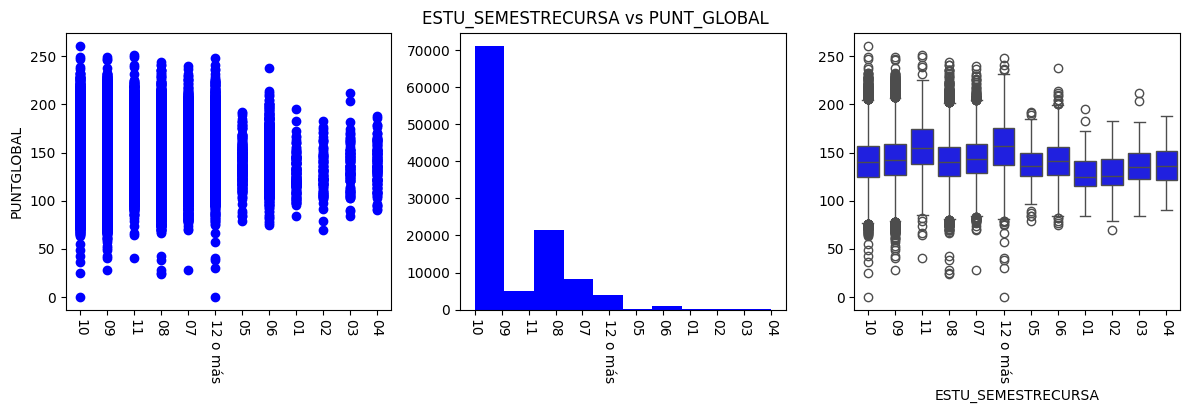

C:\Users\MrDroky\AppData\Local\Temp\ipykernel_18204\754197639.py:26: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  d.tight_layout()


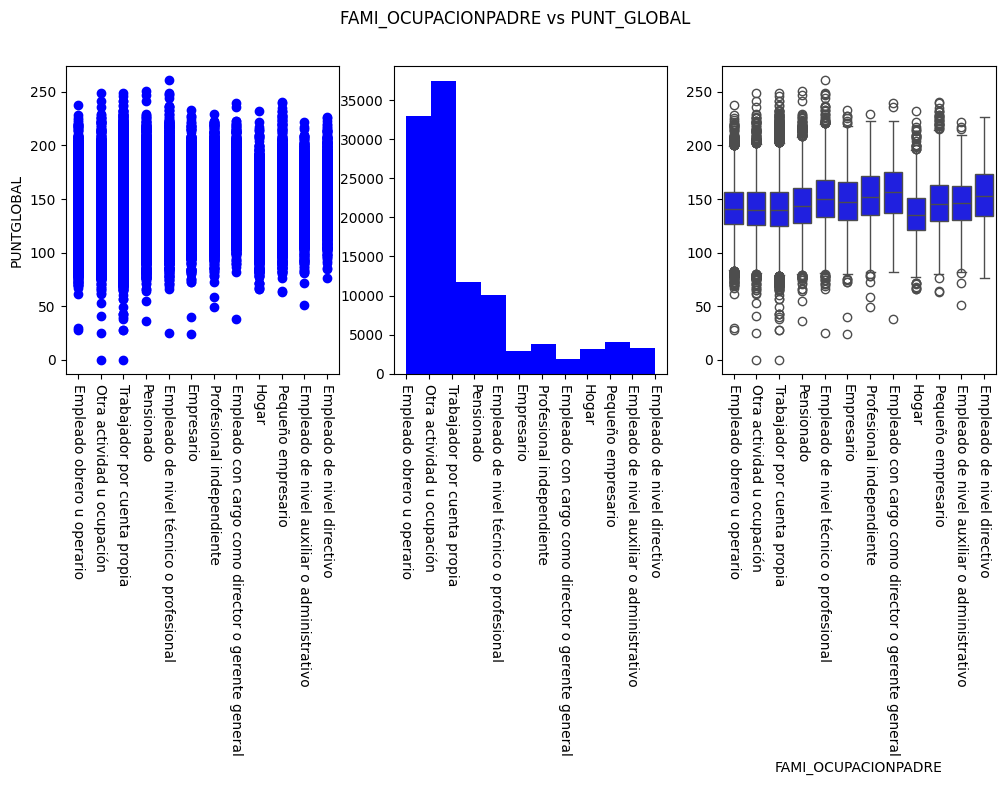

C:\Users\MrDroky\AppData\Local\Temp\ipykernel_18204\754197639.py:26: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  d.tight_layout()


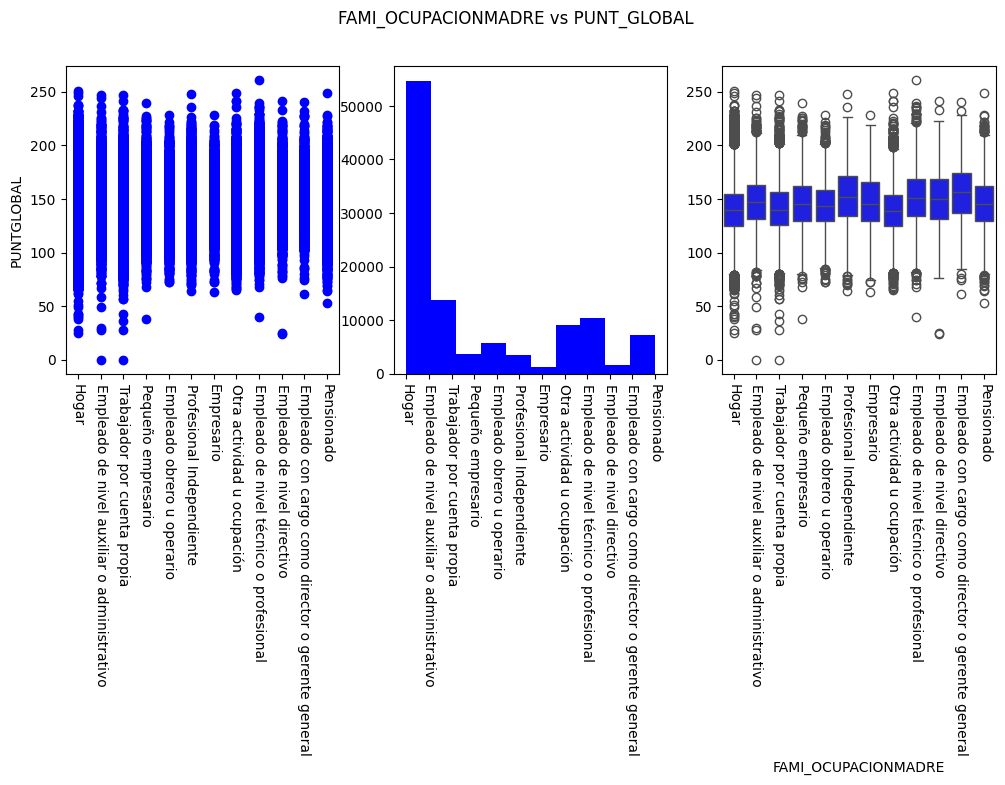

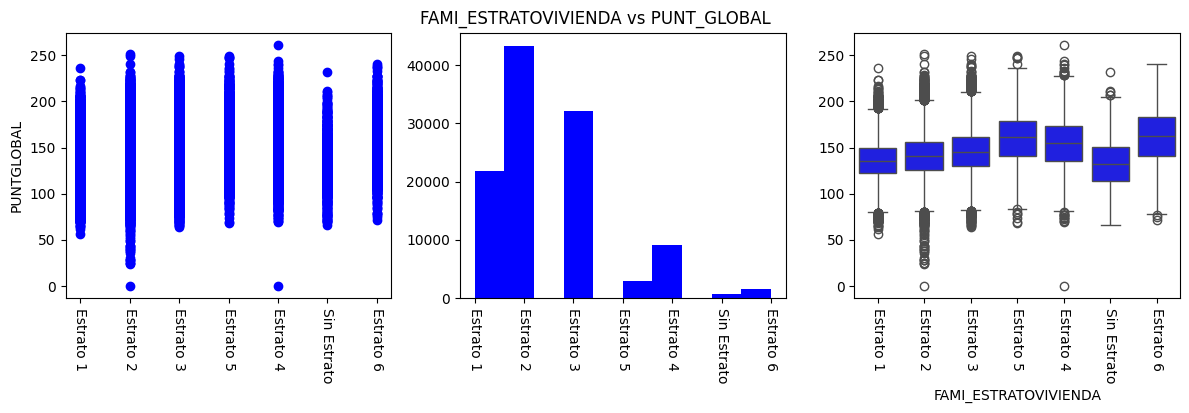

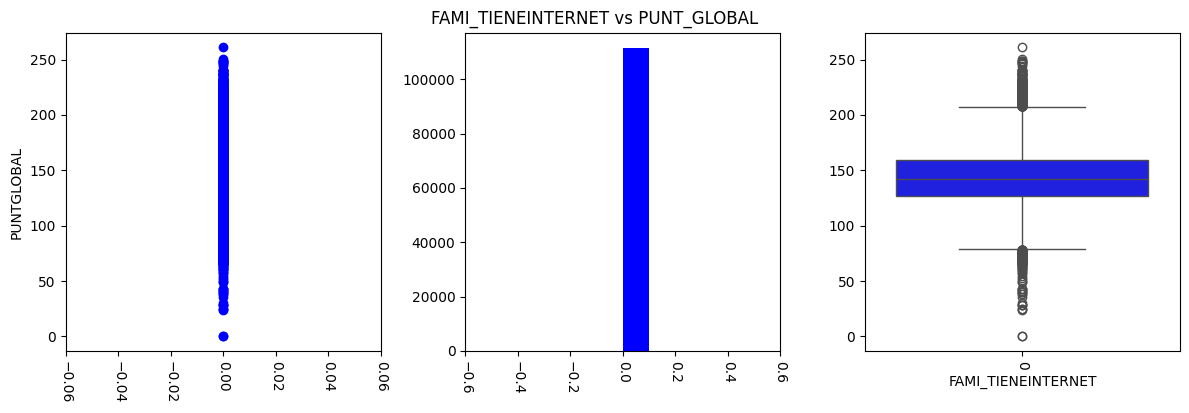

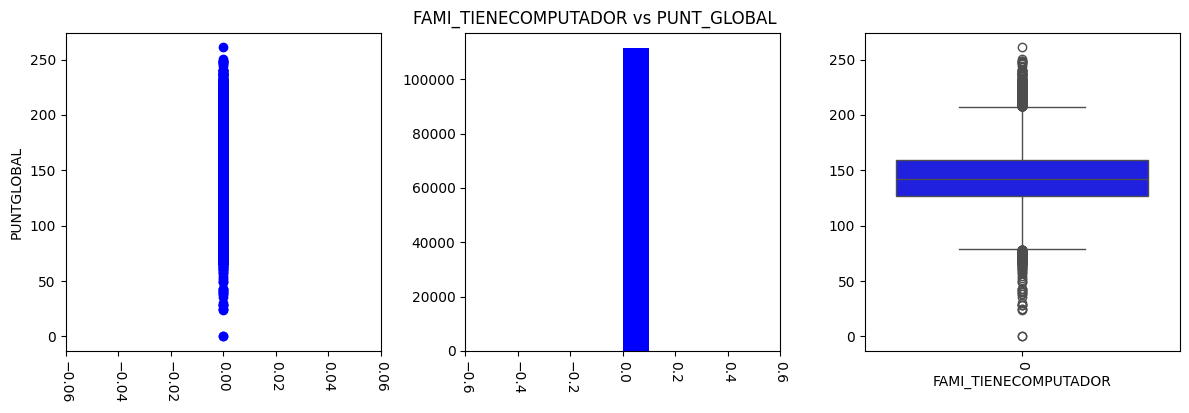

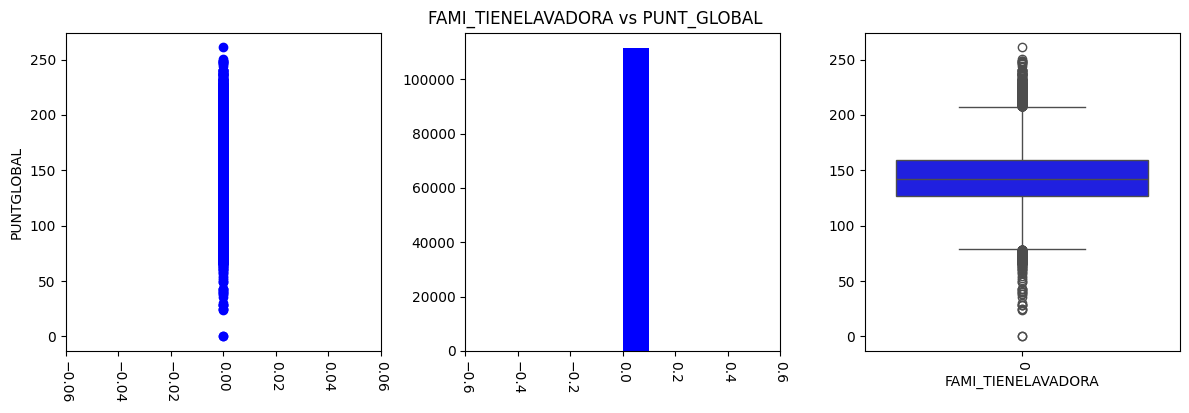

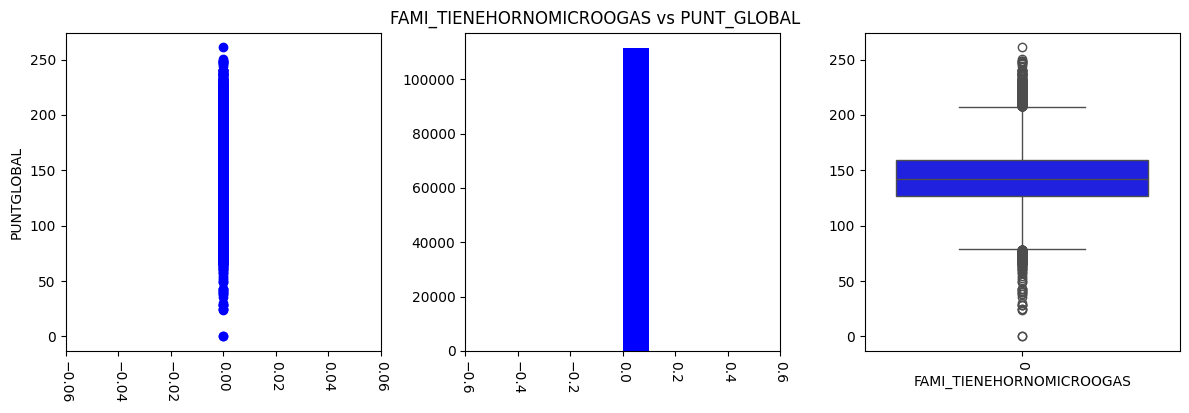

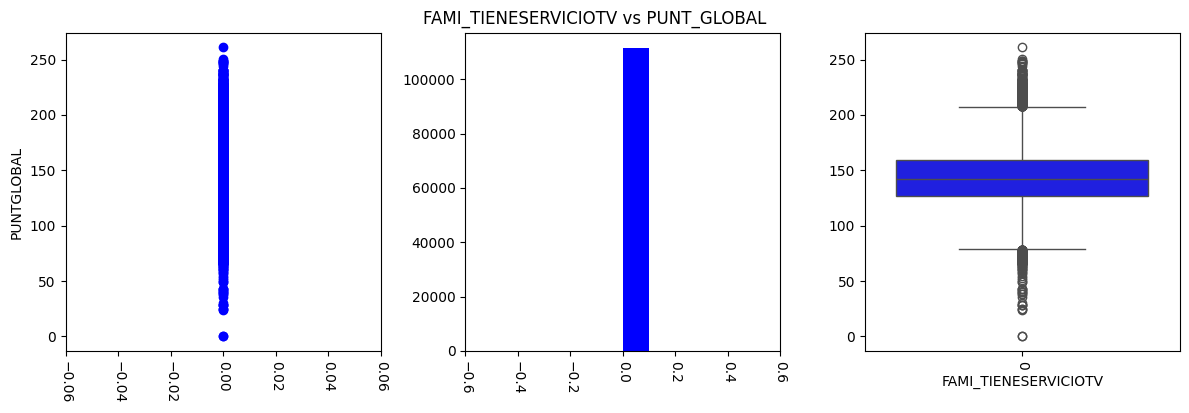

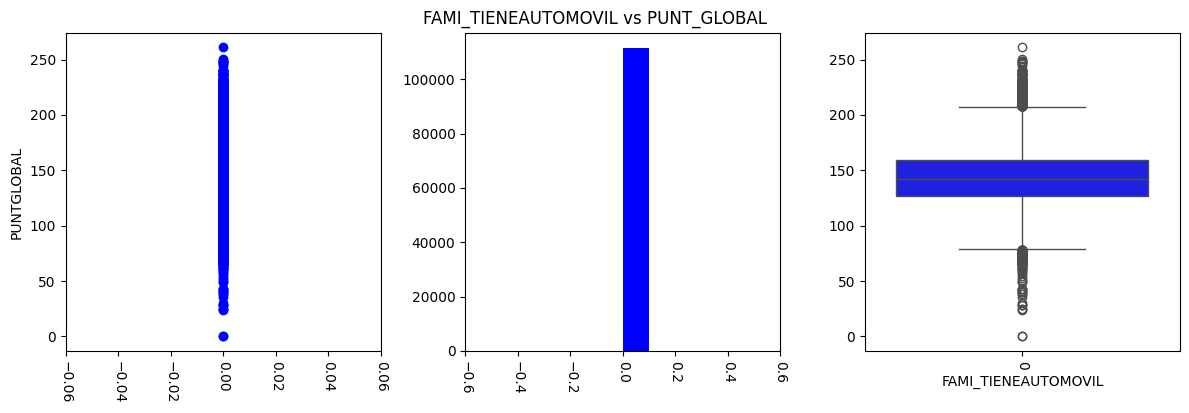

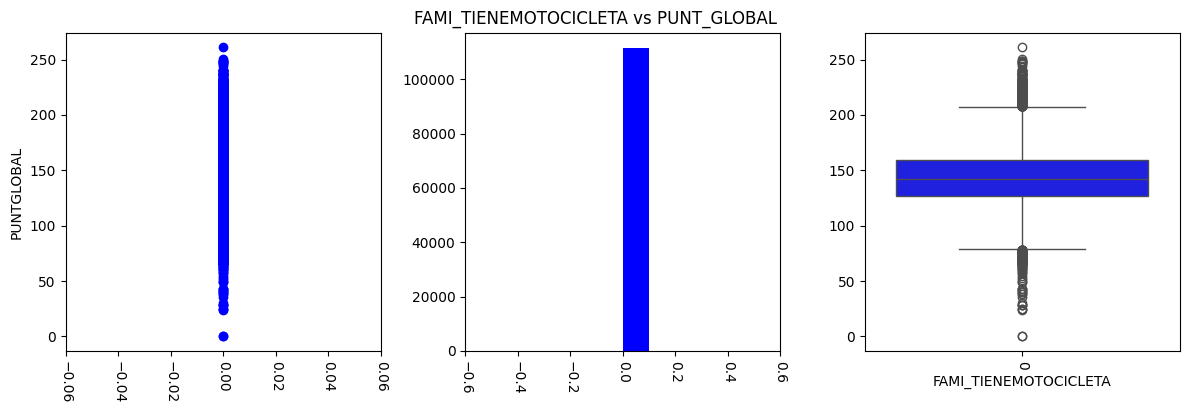

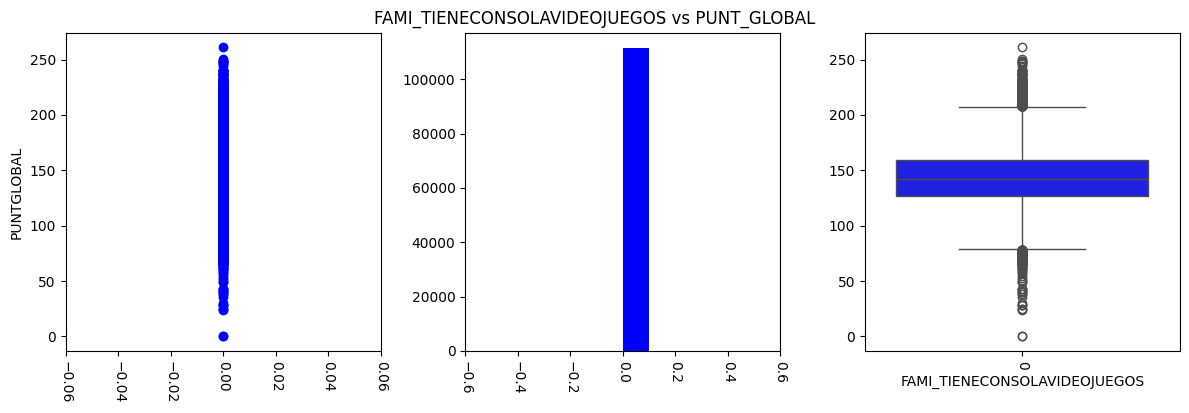

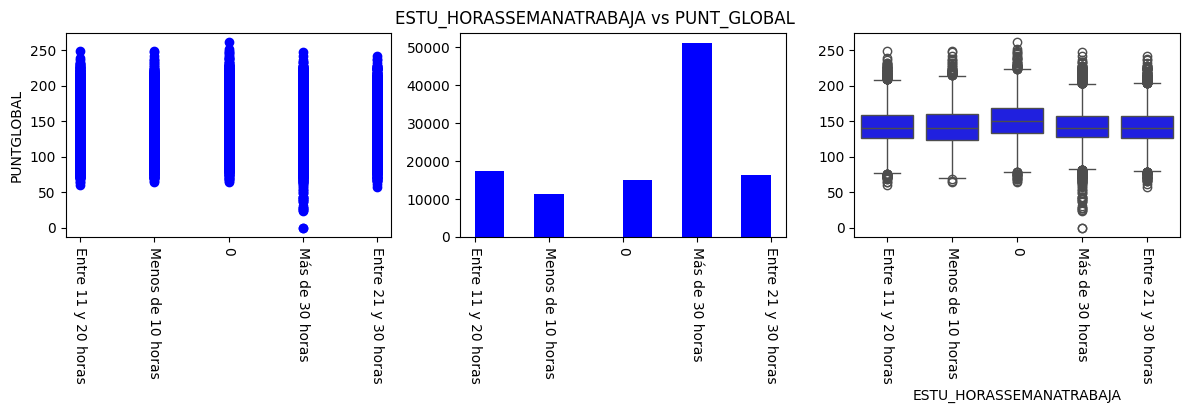

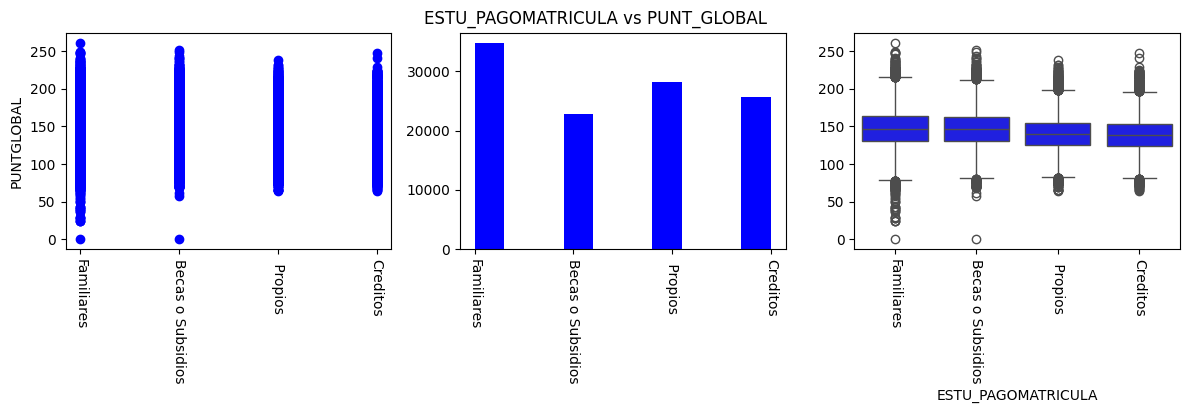

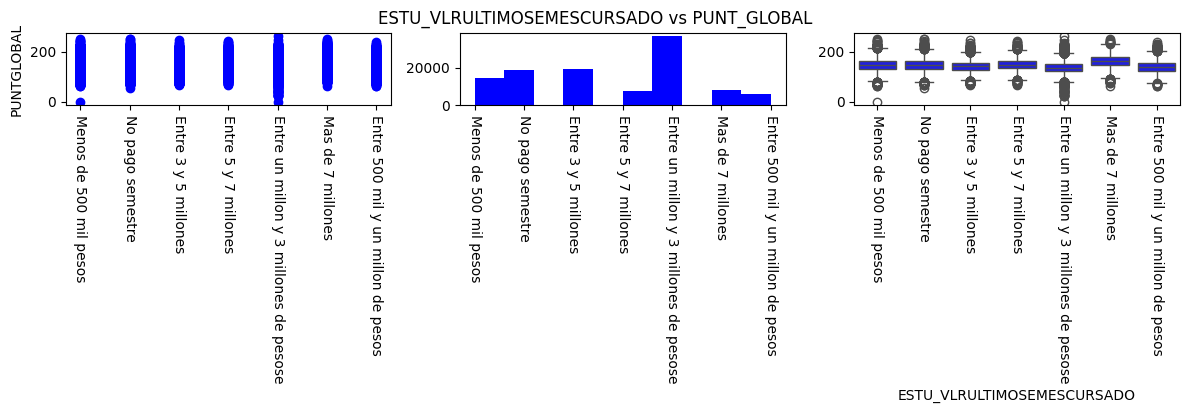

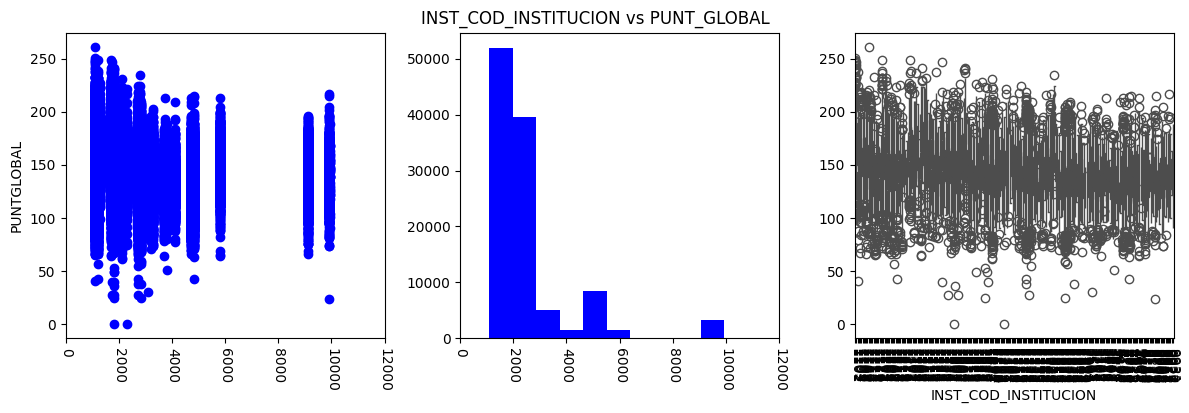

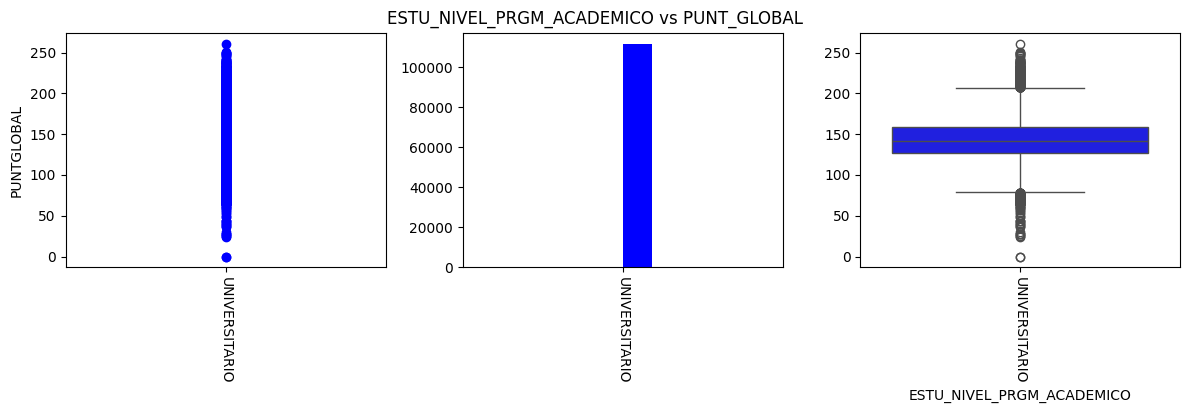

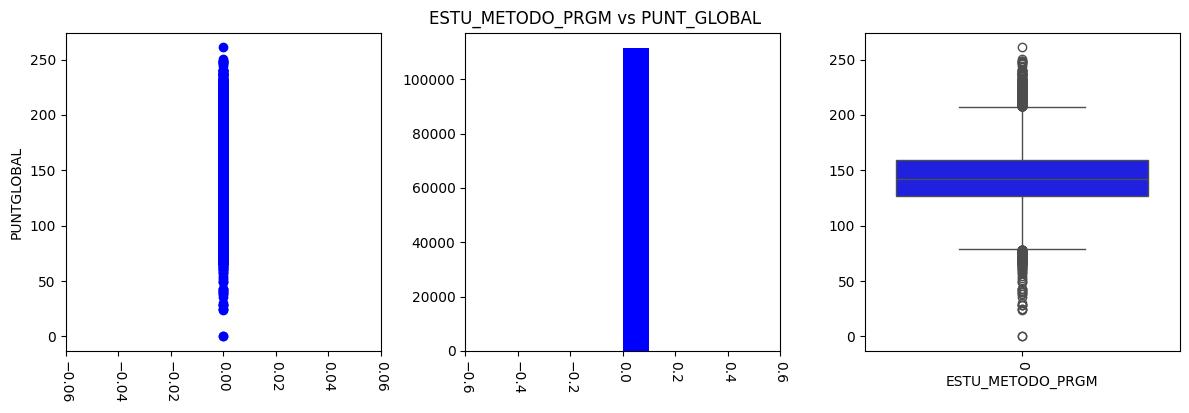

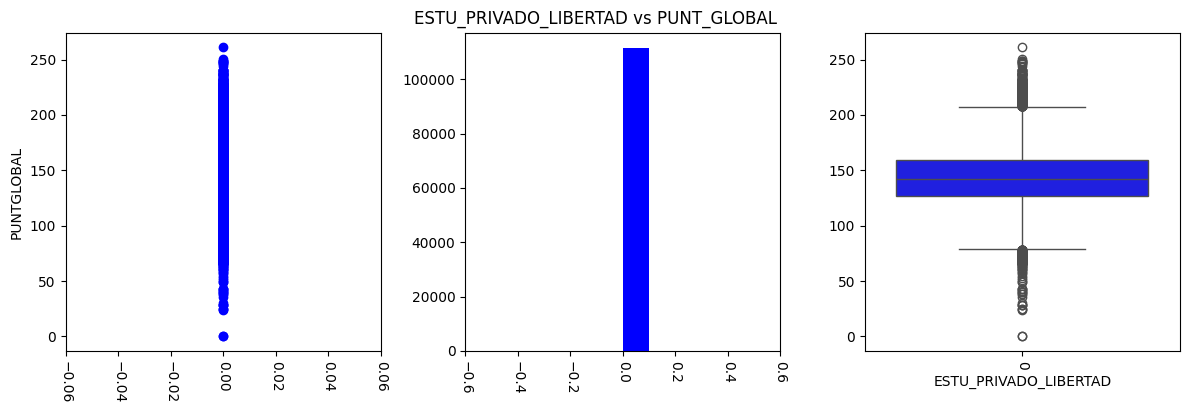

In [30]:
for col in categorical_cols:

    # Crear la figura y los subplots
    d, ax = plt.subplots(ncols=3, figsize=(12, 4))

    # Scatter plot
    ax[0].scatter(est_train[col], est_train["PUNT_GLOBAL"], c="blue")
    ax[0].set_ylabel("PUNTGLOBAL")
    ax[0].set_xticks(ax[0].get_xticks())
    ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=-90)

    # Histograma
    ax[1].hist(est_train[col], color="blue")
    ax[1].set_xticks(ax[1].get_xticks())
    ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=-90)

    # Boxplot (si aplica)
    if col != "ESTU_FECHANACIMIENTO":
        sns.boxplot(x=est_train[col], y=est_train["PUNT_GLOBAL"], ax=ax[2], color="blue")
        ax[2].set_xlabel(col)
        ax[2].set_ylabel("")
        ax[2].set_xticks(ax[2].get_xticks())
        ax[2].set_xticklabels(ax[2].get_xticklabels(), rotation=-90)

    # Ajustar el diseño y agregar título
    d.tight_layout()
    plt.suptitle(f"{col} vs PUNT_GLOBAL", y=1.02)
    plt.show()

### 2. Divida los datos en training y testing

In [31]:
x, y = est_train_dumm[[col for col in est_train_dumm.columns if col != "PUNT_GLOBAL"]], est_train["PUNT_GLOBAL"]
xr, xs, yr, ys = train_test_split(x, y, test_size=0.2, random_state=42)

#### 2.1 Aplique las transformaciones más importantes a los datos. (Hint calcular la edad basada en la fecha de nacimiento, agrupar variables categóricas con mucha cardinalidad en grupos).



In [32]:
est_train

,ESTU_GENERO,ESTU_FECHANACIMIENTO,ESTU_EXTERIOR,ESTU_AREARESIDE,ESTU_TITULOOBTENIDOBACHILLER,ESTU_VALORMATRICULAUNIVERSIDAD,ESTU_PAGOMATRICULABECA,ESTU_PAGOMATRICULACREDITO,ESTU_PAGOMATRICULAPADRES,ESTU_PAGOMATRICULAPROPIO,...,ESTU_PAGOMATRICULA,ESTU_VLRULTIMOSEMESCURSADO,INST_COD_INSTITUCION,ESTU_NIVEL_PRGM_ACADEMICO,ESTU_METODO_PRGM,ESTU_PRIVADO_LIBERTAD,PUNT_GLOBAL,ESTU_INSE_INDIVIDUAL,ESTU_NSE_INDIVIDUAL,ESTU_NSE_IES
0,0,55,0,0,Bachiller académico,Entre 500 mil y menos de 1 millón,0,0,0,0,...,Familiares,Menos de 500 mil pesos,1202,UNIVERSITARIO,0,0,188,55.570156,3.000000,2
1,0,55,0,0,Bachiller académico,Entre 1 millón y menos de 2.5 millones,0,0,0,0,...,Becas o Subsidios,Menos de 500 mil pesos,2102,UNIVERSITARIO,0,0,140,38.105883,1.000000,2
2,0,55,0,0,Bachiller académico,Entre 1 millón y menos de 2.5 millones,0,0,0,0,...,Becas o Subsidios,Menos de 500 mil pesos,2102,UNIVERSITARIO,0,0,140,65.658631,4.000000,2
3,0,55,0,0,Bachiller académico,No pagó matrícula,0,0,0,0,...,Becas o Subsidios,No pago semestre,1218,UNIVERSITARIO,0,0,111,49.260729,2.000000,2
4,0,55,0,0,Bachiller académico,Entre 2.5 millones y menos de 4 millones,0,0,0,0,...,Propios,Entre 3 y 5 millones,2812,UNIVERSITARIO,0,0,135,55.138843,2.000000,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111425,0,55,0,0,Bachiller técnico,No pagó matrícula,0,0,0,0,...,Familiares,Entre un millon y 3 millones de pesose,1107,UNIVERSITARIO,0,0,137,55.028124,2.678834,2
111426,0,55,0,0,Bachiller académico,Entre 4 millones y menos de 5.5 millones,0,0,0,0,...,Familiares,Entre 3 y 5 millones,1805,UNIVERSITARIO,0,0,161,63.619372,4.000000,3
111427,0,55,0,0,Bachiller académico,Entre 2.5 millones y menos de 4 millones,0,0,0,0,...,Creditos,Entre un millon y 3 millones de pesose,4702,UNIVERSITARIO,0,0,124,48.648902,2.000000,2
111428,0,55,0,0,Bachiller académico,Entre 4 millones y menos de 5.5 millones,0,0,0,0,...,Creditos,Entre 3 y 5 millones,1824,UNIVERSITARIO,0,0,142,52.877602,2.000000,4


#### 2.2 Entrenar un modelos de regresión

In [33]:
reg = LinearRegression()
reg.fit(xr, yr)

LinearRegression()

#### 2.3 ¿Cuál es el mejor R squared? Cuál es el MAPE y el MSE.

In [34]:
yr_hat = reg.predict(xr)

def get_r2(true, pred):
    SSR, SST = sum((true-pred)**2), sum((true-np.mean(true))**2)
    R2 = 1 - (float(SSR))/SST
    return R2

def get_mse(true, pred):
    return (1/len(true))*sum((true-pred)**2)

def get_mape(true, pred):
    return (100/len(true)*sum(abs(pred-true)/true))

print("Training:")
print("R²   ", get_r2(yr, yr_hat))
print("MAPE ", get_mape(yr, yr_hat), "(Hay puntajes en 0)")
print("MSE  ", get_mse(yr, yr_hat))

Training:
R²    0.20500402477094537
MAPE  inf (Hay puntajes en 0)
MSE   436.69551153635297


### 3. Remueva las variables que nos son relevantes




In [ ]:
irrelevant_cols = [
    "ESTU_TIPODOCUMENTO", "ESTU_NACIONALIDAD","PERIODO","ESTU_CONSECUTIVO","ESTU_ESTUDIANTE","ESTU_PAIS_RESIDE",
    "ESTU_DEPTO_RESIDE","ESTU_MCPIO_RESIDE","ESTU_ESTADOCIVIL","ESTU_TIPODOCUMENTOSB11","FAMI_EDUCACIONPADRE","FAMI_EDUCACIONMADRE",
    "FAMI_TRABAJOLABORPADRE","FAMI_TRABAJOLABORMADRE","FAMI_CUANTOSCOMPARTEBAÑO",
    "ESTU_PRESENTACIONCASA","ESTU_PRESENTACIONSABADO","INST_NOMBRE_INSTITUCION","ESTU_PRGM_ACADEMICO","GRUPOREFERENCIA",
    "ESTU_PRGM_MUNICIPIO","ESTU_PRGM_DEPARTAMENTO","ESTU_NUCLEO_PREGRADO","ESTU_NUCLEO_PREGRADO_1",
    "ESTU_INST_MUNICIPIO","ESTU_INST_DEPARTAMENTO","INST_CARACTER_ACADEMICO","INST_ORIGEN","ESTU_MCPIO_PRESENTACION",
    "ESTU_DEPTO_PRESENTACION","ESTU_ESTADOINVESTIGACION", "ESTU_COD_RESIDE_DEPTO", "ESTU_COD_RESIDE_MCPIO",
    "ESTU_SNIES_PRGMACADEMICO","ESTU_PRGM_CODMUNICIPIO","ESTU_INST_CODMUNICIPIO","ESTU_COD_MCPIO_PRESENTACION","ESTU_COD_DEPTO_PRESENTACION"
]

est_train = est_train_raw.drop(columns = irrelevant_cols)


### 4. Utilizando los datos de test medir el MAPE y el MSE de test. Qué tan diferentes son las métricas de training. (El menor error del grupo tiene un +1)

In [35]:
ys_hat = reg.predict(xs)

print("Test:")
print("R²   ", get_r2(ys, ys_hat))
print("MAPE ", get_mape(ys, ys_hat), "(Hay puntajes en 0)")
print("MSE  ", get_mse(ys, ys_hat))

Test:
R²    0.2111880612008481
MAPE  inf (Hay puntajes en 0)
MSE   436.84152295813686


No hay mucha diferencia respecto al training.

### 5. Describa en palabras que dice el modelo cuales son los principales hallazgos.

El principal hallazgo es que el las variables seleccionadas no son buenas para explicar la variabilidad del puntaje global, ya que se obtuvo un valor un poco bajo. 

In [38]:
est_test_raw = pd.read_csv("./Insumos/test_pruebas.csv", low_memory=False)
est_test = est_test_raw.drop(columns=irrelevant_cols)
est_test = fix_nulls(est_test)
transform_data(est_test)
est_test_dumm = pd.get_dummies(est_test)
normalize(est_test_dumm)
est_test_dumm

,ESTU_GENERO,ESTU_FECHANACIMIENTO,ESTU_EXTERIOR,ESTU_AREARESIDE,ESTU_PAGOMATRICULABECA,ESTU_PAGOMATRICULACREDITO,ESTU_PAGOMATRICULAPADRES,ESTU_PAGOMATRICULAPROPIO,ESTU_SIMULACROTIPOICFES,ESTU_ACTIVIDADREFUERZOAREAS,...,ESTU_PAGOMATRICULA_Creditos,ESTU_PAGOMATRICULA_Familiares,ESTU_VLRULTIMOSEMESCURSADO_Entre 3 y 5 millones,ESTU_VLRULTIMOSEMESCURSADO_Entre 5 y 7 millones,ESTU_VLRULTIMOSEMESCURSADO_Entre 500 mil y un millon de pesos,ESTU_VLRULTIMOSEMESCURSADO_Entre un millon y 3 millones de pesose,ESTU_VLRULTIMOSEMESCURSADO_Mas de 7 millones,ESTU_VLRULTIMOSEMESCURSADO_Menos de 500 mil pesos,ESTU_VLRULTIMOSEMESCURSADO_No pago semestre,ESTU_NIVEL_PRGM_ACADEMICO_UNIVERSITARIO
0,0.873960,3.005238,-0.122216,0.362459,-0.653165,1.643914,-0.833058,-0.946695,0.075763,0.09706,...,1.853608,-0.675279,-0.454813,-0.269317,-0.245202,1.425919,-0.275324,-0.391896,-0.454123,0
1,-1.144175,-0.424237,-0.122216,0.362459,1.530951,-0.608282,-0.833058,-0.946695,0.075763,0.09706,...,1.853608,-0.675279,-0.454813,3.712968,-0.245202,-0.701277,-0.275324,-0.391896,-0.454123,0
2,0.873960,-0.281342,-0.122216,0.362459,-0.653165,-0.608282,-0.833058,-0.946695,0.075763,0.09706,...,-0.539469,-0.675279,-0.454813,-0.269317,-0.245202,-0.701277,-0.275324,-0.391896,2.201967,0
3,0.873960,0.290237,-0.122216,0.362459,-0.653165,-0.608282,1.200354,-0.946695,0.075763,0.09706,...,-0.539469,1.480816,-0.454813,-0.269317,-0.245202,1.425919,-0.275324,-0.391896,-0.454123,0
4,0.873960,0.290237,8.181928,0.362459,-0.653165,-0.608282,-0.833058,-0.946695,0.075763,0.09706,...,-0.539469,1.480816,-0.454813,-0.269317,-0.245202,1.425919,-0.275324,-0.391896,-0.454123,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27853,0.873960,0.576026,-0.122216,0.362459,-0.653165,1.643914,-0.833058,1.056269,0.075763,0.09706,...,-0.539469,-0.675279,-0.454813,-0.269317,-0.245202,1.425919,-0.275324,-0.391896,-0.454123,0
27854,-1.144175,-0.710027,-0.122216,0.362459,-0.653165,1.643914,1.200354,-0.946695,0.075763,0.09706,...,-0.539469,-0.675279,2.198627,-0.269317,-0.245202,-0.701277,-0.275324,-0.391896,-0.454123,0
27855,0.873960,3.433922,-0.122216,0.362459,1.530951,-0.608282,-0.833058,-0.946695,0.075763,0.09706,...,1.853608,-0.675279,-0.454813,-0.269317,-0.245202,-0.701277,-0.275324,2.551605,-0.454123,0
27856,0.873960,-0.138447,-0.122216,0.362459,-0.653165,-0.608282,1.200354,1.056269,0.075763,0.09706,...,-0.539469,-0.675279,-0.454813,-0.269317,-0.245202,1.425919,-0.275324,-0.391896,-0.454123,0


In [41]:
est_test_pred = reg.predict(est_test_dumm)
output = pd.DataFrame(est_test_pred, columns=["GLOBAL_SCORE"])

with open("./output/Regression.csv", mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["id","GLOBAL_SCORE"])
    for i, val in enumerate(np.array(output["GLOBAL_SCORE"])):
        writer.writerow([est_test_raw["ESTU_CONSECUTIVO"][i],val])

output

,GLOBAL_SCORE
0,-9.387080e+13
1,4.340192e+13
2,2.945879e+13
3,1.473392e+12
4,-1.008832e+14
...,...
27853,-4.900757e+12
27854,2.646796e+13
27855,-9.368328e+13
27856,3.523070e+13


## Crear un modelo de KNN

Utilizar los datos para crear un modelo de KNN que permita predecir el puntaje por estudiante.

In [42]:
x, y = est_train_dumm[[col for col in est_train_dumm.columns if col != "PUNT_GLOBAL"]], est_train["PUNT_GLOBAL"]
xr, xs, yr, ys = train_test_split(x, y, test_size=0.2, random_state=42)

### 2.1 Hacer pruebas con 5, 10, 20 y 30 vecinos. Seleccione el numero de vecinos basado en el error de test MSE.

In [43]:
neightbor_sizes = [5,10,20,30]

for s in neightbor_sizes:
    knn = KNeighborsRegressor(n_neighbors=s)
    knn.fit(xr, yr)
    yr_hat = knn.predict(xr)
    print(f"{s} vecinos:")
    print("MSE(train)   ", get_mse(yr, yr_hat))
    print("MAPE(train)  ", get_mape(yr, yr_hat))

    ys_hat = knn.predict(xs)
    print("MSE(test)    ", get_mse(ys, ys_hat))
    print("MAPE(test)   ", get_mape(ys, ys_hat))

    print("---------------------------------")

5 vecinos:
MSE(train)    344.8359799874361
MAPE(train)   inf
MSE(test)     521.5558826168905
MAPE(test)    inf
---------------------------------
10 vecinos:
MSE(train)    390.7110664767107
MAPE(train)   inf
MSE(test)     479.7187427084255
MAPE(test)    inf
---------------------------------
20 vecinos:
MSE(train)    415.47219462330673
MAPE(train)   inf
MSE(test)     461.43715729606066
MAPE(test)    inf
---------------------------------
30 vecinos:
MSE(train)    424.65671277182713
MAPE(train)   inf
MSE(test)     456.29198385633384
MAPE(test)    inf
---------------------------------


El MSE de test mejora con cada vez más vecinos, así que voy a probar con 100.

In [44]:
knn = KNeighborsRegressor(n_neighbors=100)
knn.fit(xr, yr)
ys_hat = knn.predict(xs)
print("100 vecinos:")
print("MSE(test)    ", get_mse(ys, ys_hat))
print("MAPE(test)   ", get_mape(ys, ys_hat))

est_test_pred = knn.predict(est_test_dumm)
output = pd.DataFrame(est_test_pred, columns=["GLOBAL_SCORE"])

with open("output/KNN.csv", mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["id","GLOBAL_SCORE"])
    for i, val in enumerate(np.array(output["GLOBAL_SCORE"])):
        writer.writerow([est_test_raw["ESTU_CONSECUTIVO"][i],val])

output

100 vecinos:
MSE(test)     454.06516622543325
MAPE(test)    inf


,GLOBAL_SCORE
0,130.12
1,142.14
2,144.87
3,132.19
4,138.24
...,...
27853,133.32
27854,140.03
27855,142.96
27856,138.97


### 2.2 Describa cual es mejor modelo entre la regresión o el knn.

En general, la regresión lineal resulta ser más efectiva

## 3. Crear un modelo de GBM

Entrenar un modelo de GBM y hacer la predicción. Cual es el MSE y MAPE para train y test.

In [45]:
x, y = est_train_dumm[[col for col in est_train_dumm.columns if col != "PUNT_GLOBAL"]], est_train["PUNT_GLOBAL"]
xr, xs, yr, ys = train_test_split(x, y, test_size=0.2, random_state=42)

gbm = LGBMClassifier(n_estimators=100, learning_rate=0.1, random_state=42, verbose=0)
gbm.fit(xr, yr)

yr_hat = gbm.predict(xr)

print("Train: ")
print("MSE(train)    ", get_mse(yr, yr_hat))
print("MAPE(train)   ", get_mape(yr, yr_hat))

ys_hat = gbm.predict(xs)

print("Test: ")
print("MSE(test)    ", get_mse(ys, ys_hat))
print("MAPE(test)   ", get_mape(ys, ys_hat))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

In [46]:
est_test_pred = gbm.predict(est_test_dumm)
output = pd.DataFrame(est_test_pred, columns=["GLOBAL_SCORE"])

with open("./output/GBM.csv", mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["id","GLOBAL_SCORE"])
    for i, val in enumerate(np.array(output["GLOBAL_SCORE"])):
        writer.writerow([est_test_raw["ESTU_CONSECUTIVO"][i],val])

output

,GLOBAL_SCORE
0,129
1,129
2,129
3,129
4,129
...,...
27853,129
27854,129
27855,129
27856,129


## 4. Crear un modelo de regresión logística

Utiliza los mismos datos del punto 1, crea una variable Y donde las personas con puntajemayor a 172 tienen “1” y los demás “0” (‘1’ if PUNT_GLOBAL>172 else ‘0’), la variable Y representa los estudiantes sobresalientes, eliminar la variable PUNT_GLOBAL.

In [47]:
x, y = est_train_dumm[[col for col in est_train_dumm.columns if col != "PUNT_GLOBAL"]], (est_train["PUNT_GLOBAL"] > 172).astype(int)

Con el dataset de training:
- Dividir los datos en training 80% y validación 20%.
- Entrenar una regresión logística, cuales son las variables más importantes?.
- Crear una matriz de confusión, cual es la precisión, cuál es el recall, y el accuracy.
- Calcular las mismas métricas para el dataset de validación.

In [48]:
xr, xs, yr, ys = train_test_split(x, y, test_size=0.2, random_state=42)

lgr = LogisticRegression()
lgr.fit(xr, yr)

yr_hat = lgr.predict(xr)

print("Regresión logítisca")
print("MSE(train):", get_mse(yr_hat, yr))

ys_hat = lgr.predict(xs)

print("MSE(test):", get_mse(ys_hat, ys))

Regresión logítisca
MSE(train): 0.1128398994884681
MSE(test): 0.11518442071255497


La importancia la determinaré con los coeficientes, están organizadas por el valor del coeficiente.

In [49]:
importance = pd.DataFrame({'Variable': est_test_dumm.columns, 'Coeficiente': lgr.coef_[0]}).sort_values(ascending=False, by=["Coeficiente"]).iloc[1:]
importance

,Variable,Coeficiente
22,ESTU_INSE_INDIVIDUAL,0.284156
106,ESTU_VLRULTIMOSEMESCURSADO_No pago semestre,0.195500
87,FAMI_ESTRATOVIVIENDA_Estrato 4,0.192055
86,FAMI_ESTRATOVIVIENDA_Estrato 3,0.137235
105,ESTU_VLRULTIMOSEMESCURSADO_Menos de 500 mil pesos,0.135036
...,...,...
100,ESTU_VLRULTIMOSEMESCURSADO_Entre 3 y 5 millones,-0.107661
101,ESTU_VLRULTIMOSEMESCURSADO_Entre 5 y 7 millones,-0.117382
98,ESTU_PAGOMATRICULA_Creditos,-0.131785
84,FAMI_ESTRATOVIVIENDA_Estrato 1,-0.313373


In [50]:
conf_r = pd.DataFrame(metrics.confusion_matrix(yr, yr_hat))
print("Filas: Real, Columnas: Predicción\n")
print("Matríz de confusión (Train)")
conf_r

Filas: Real, Columnas: Predicción

Matríz de confusión (Train)


,0,1
0,77805,921
1,9138,1280


In [51]:
pre_r, acc_r, rec_r = precision_score(yr, yr_hat), accuracy_score(yr, yr_hat), recall_score(yr, yr_hat)
print("PRECISION:",pre_r)
print("ACCURACY:",acc_r)
print("RECALL:", rec_r)

PRECISION: 0.5815538391640164
ACCURACY: 0.8871601005115319
RECALL: 0.12286427337300826


In [52]:
conf_s = pd.DataFrame(metrics.confusion_matrix(ys, ys_hat))
print("Matríz de confusión (Test)")
conf_s

Matríz de confusión (Test)


,0,1
0,19375,251
1,2316,344


In [53]:
pre_s, acc_s, rec_s = precision_score(ys, ys_hat), accuracy_score(ys, ys_hat), recall_score(ys, ys_hat)
print("PRECISION:",pre_s)
print("ACCURACY:",acc_s)
print("RECALL:", rec_s)

PRECISION: 0.5781512605042017
ACCURACY: 0.884815579287445
RECALL: 0.1293233082706767
